In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error, mean_squared_error, accuracy_score, log_loss, classification_report
from sklearn.metrics import roc_auc_score

import seaborn as sns
from collections import Counter

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)

In [2]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)
submission = pd.read_csv('sample_submission.csv', header=0)

In [3]:
# Concatination the training and testing data

df_train['train_flag'] = 1
df_test['train_flag'] = 0
df_test['Crop_Damage'] = 0

print(df_train.shape, df_test.shape)

df_data = pd.concat((df_train, df_test))
print(df_data.shape)

(88858, 11) (59310, 11)
(148168, 11)


In [5]:
# X is feature_cols and y is label_cols

feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('train_flag')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season']


In [6]:
#Removing the 'F' from ID and storing as new columns

df_data['ID_value'] = df_data['ID'].apply(lambda x: x.strip('F')).astype('int')

In [9]:
df_data = df_data.reset_index(drop=True)
df_data

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,train_flag,ID_value
0,F00000001,188,1,0,1,0,0.0,0,1,0,1,1
1,F00000002,188,1,1,1,0,NaN,0,2,0,0,2
2,F00000003,209,1,0,1,0,0.0,0,2,1,1,3
3,F00000004,257,1,0,1,0,0.0,0,2,1,1,4
4,F00000005,257,1,1,1,0,0.0,0,2,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
148163,F00155941,3702,1,0,2,10,NaN,48,1,0,0,155941
148164,F00155942,3702,1,0,2,10,25.0,18,3,0,1,155942
148165,F00155943,3702,1,0,2,10,28.0,17,2,0,0,155943
148166,F00155944,3895,1,0,2,5,52.0,7,1,0,0,155944


In [13]:
df_data['Soil_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values
    
df_data['Estimated_Insects_Count_Damage'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift().rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Soil_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Soil_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Estimated_Insects_Count_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Estimated_Insects_Count'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Crop_Type_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Crop_Type'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Pesticide_Use_Category_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Pesticide_Use_Category'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

df_data['Season_Damage_lag2'] = df_data.sort_values(['ID_value']).groupby(['Season'])['Crop_Damage'].apply(lambda x: x.shift(periods=2).rolling(5, min_periods=1).mean()).fillna(-999).values

In [14]:
df_data.loc[df_data['train_flag'] == 0, 'Crop_Damage'] = -999

In [15]:
df_data['Crop_Damage_lag1'] = df_data['Crop_Damage'].shift(fill_value=-999)
df_data['Estimated_Insects_Count_lag1'] = df_data['Estimated_Insects_Count'].shift(fill_value=-999)
df_data['Crop_Type_lag1'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag1'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag1'] = df_data['Pesticide_Use_Category'].shift(fill_value=-999)
df_data['Number_Doses_Week_lag1'] = df_data['Number_Doses_Week'].shift(fill_value=-999)
df_data['Number_Weeks_Used_lag1'] = df_data['Number_Weeks_Used'].shift(fill_value=-999)
df_data['Number_Weeks_Quit_lag1'] = df_data['Number_Weeks_Quit'].shift(fill_value=-999)
df_data['Season_lag1'] = df_data['Season'].shift(fill_value=-999)

df_data['Crop_Damage_lag2'] = df_data['Crop_Damage'].shift(periods=2,fill_value=-999)
df_data['Estimated_Insects_Count_lag2'] = df_data['Estimated_Insects_Count'].shift(periods=2,fill_value=-999)
df_data['Crop_Type_lag2'] = df_data['Crop_Type'].shift(fill_value=-999)
df_data['Soil_Type_lag2'] = df_data['Soil_Type'].shift(fill_value=-999)
df_data['Pesticide_Use_Category_lag2'] = df_data['Pesticide_Use_Category'].shift(periods=2,fill_value=-999)
df_data['Number_Doses_Week_lag2'] = df_data['Number_Doses_Week'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Used_lag2'] = df_data['Number_Weeks_Used'].shift(periods=2,fill_value=-999)
df_data['Number_Weeks_Quit_lag2'] = df_data['Number_Weeks_Quit'].shift(periods=2,fill_value=-999)
df_data['Season_lag2'] = df_data['Season'].shift(periods=2,fill_value=-999)


In [16]:
df_train, df_test = df_data[df_data.train_flag == 1], df_data[df_data.train_flag == 0]

In [17]:
df_train.drop(['train_flag'], inplace=True, axis=1)
df_test.drop(['train_flag'], inplace=True, axis=1)
df_test.drop([label_col], inplace=True, axis=1)

In [18]:
print(df_train.shape, df_test.shape)

(88858, 39) (59310, 38)


In [19]:
del df_data

In [20]:
missing_impute = -999

In [21]:
df_train['Number_Weeks_Used'] = df_train['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used'] = df_test['Number_Weeks_Used'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag1'] = df_train['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag1'] = df_test['Number_Weeks_Used_lag1'].apply(lambda x: missing_impute if pd.isna(x) else x)

df_train['Number_Weeks_Used_lag2'] = df_train['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)
df_test['Number_Weeks_Used_lag2'] = df_test['Number_Weeks_Used_lag2'].apply(lambda x: missing_impute if pd.isna(x) else x)

In [22]:
df_train, df_eval = train_test_split(df_train, test_size=0.40, random_state=42, shuffle=True, stratify=df_train[label_col])

In [23]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('ID')
feature_cols.remove('Crop_Damage')
feature_cols.remove('ID_value')
label_col = 'Crop_Damage'
print(feature_cols)

['Estimated_Insects_Count', 'Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Number_Doses_Week', 'Number_Weeks_Used', 'Number_Weeks_Quit', 'Season', 'Soil_Type_Damage', 'Estimated_Insects_Count_Damage', 'Crop_Type_Damage', 'Pesticide_Use_Category_Damage', 'Season_Damage', 'Soil_Type_Damage_lag2', 'Estimated_Insects_Count_Damage_lag2', 'Crop_Type_Damage_lag2', 'Pesticide_Use_Category_Damage_lag2', 'Season_Damage_lag2', 'Crop_Damage_lag1', 'Estimated_Insects_Count_lag1', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Number_Doses_Week_lag1', 'Number_Weeks_Used_lag1', 'Number_Weeks_Quit_lag1', 'Season_lag1', 'Crop_Damage_lag2', 'Estimated_Insects_Count_lag2', 'Crop_Type_lag2', 'Soil_Type_lag2', 'Pesticide_Use_Category_lag2', 'Number_Doses_Week_lag2', 'Number_Weeks_Used_lag2', 'Number_Weeks_Quit_lag2', 'Season_lag2']


In [24]:
cat_cols = ['Crop_Type', 'Soil_Type', 'Pesticide_Use_Category', 'Season', 'Crop_Type_lag1', 'Soil_Type_lag1', 'Pesticide_Use_Category_lag1', 'Season_lag1']

In [25]:
params = {}
params['learning_rate'] = 0.04
params['max_depth'] = 18
params['n_estimators'] = 3000
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.7
params['reg_lambda'] = 1.11
params['class_weight']: {0: 0.44, 1: 0.4, 2: 0.37}

In [26]:
clf = lgb.LGBMClassifier(**params)
    
clf.fit(df_train[feature_cols], df_train[label_col], early_stopping_rounds=100, eval_set=[(df_train[feature_cols], df_train[label_col]), (df_eval[feature_cols], df_eval[label_col])], eval_metric='multi_error', verbose=True, categorical_feature=cat_cols)

eval_score = accuracy_score(df_eval[label_col], clf.predict(df_eval[feature_cols]))

print('Eval ACC: {}'.format(eval_score))

[1]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.497166	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.497335
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.478658	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.479165
[3]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.462451	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.463087
[4]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.447691	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.448475
[5]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.434232	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.435239
[6]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.423808	valid_1's multi_error: 0.164528	valid_1's multi_logloss: 0.425099
[7]	valid_0's multi_error: 0.164535	valid_0's multi_logloss: 0.41312	valid_1's multi_error: 0.164528	valid_1's multi_loglo

[62]	valid_0's multi_error: 0.0761901	valid_0's multi_logloss: 0.222497	valid_1's multi_error: 0.0772845	valid_1's multi_logloss: 0.230619
[63]	valid_0's multi_error: 0.0761151	valid_0's multi_logloss: 0.221678	valid_1's multi_error: 0.077172	valid_1's multi_logloss: 0.229924
[64]	valid_0's multi_error: 0.0758337	valid_0's multi_logloss: 0.220741	valid_1's multi_error: 0.076975	valid_1's multi_logloss: 0.229051
[65]	valid_0's multi_error: 0.0754586	valid_0's multi_logloss: 0.219378	valid_1's multi_error: 0.0763561	valid_1's multi_logloss: 0.227786
[66]	valid_0's multi_error: 0.075196	valid_0's multi_logloss: 0.21804	valid_1's multi_error: 0.0760747	valid_1's multi_logloss: 0.226556
[67]	valid_0's multi_error: 0.0748959	valid_0's multi_logloss: 0.217064	valid_1's multi_error: 0.0759622	valid_1's multi_logloss: 0.225673
[68]	valid_0's multi_error: 0.074577	valid_0's multi_logloss: 0.215736	valid_1's multi_error: 0.0760185	valid_1's multi_logloss: 0.224428
[69]	valid_0's multi_error: 0.07

[122]	valid_0's multi_error: 0.062629	valid_0's multi_logloss: 0.180304	valid_1's multi_error: 0.0661715	valid_1's multi_logloss: 0.194125
[123]	valid_0's multi_error: 0.0625539	valid_0's multi_logloss: 0.179969	valid_1's multi_error: 0.066059	valid_1's multi_logloss: 0.19391
[124]	valid_0's multi_error: 0.0624039	valid_0's multi_logloss: 0.179575	valid_1's multi_error: 0.0659464	valid_1's multi_logloss: 0.193616
[125]	valid_0's multi_error: 0.0622163	valid_0's multi_logloss: 0.17916	valid_1's multi_error: 0.0659183	valid_1's multi_logloss: 0.193303
[126]	valid_0's multi_error: 0.0620475	valid_0's multi_logloss: 0.178657	valid_1's multi_error: 0.0658902	valid_1's multi_logloss: 0.192914
[127]	valid_0's multi_error: 0.0618599	valid_0's multi_logloss: 0.178101	valid_1's multi_error: 0.0656088	valid_1's multi_logloss: 0.19246
[128]	valid_0's multi_error: 0.0615786	valid_0's multi_logloss: 0.177525	valid_1's multi_error: 0.06544	valid_1's multi_logloss: 0.191963
[129]	valid_0's multi_error

[184]	valid_0's multi_error: 0.0551637	valid_0's multi_logloss: 0.158545	valid_1's multi_error: 0.0608542	valid_1's multi_logloss: 0.17794
[185]	valid_0's multi_error: 0.0550512	valid_0's multi_logloss: 0.15839	valid_1's multi_error: 0.0609667	valid_1's multi_logloss: 0.177891
[186]	valid_0's multi_error: 0.0551075	valid_0's multi_logloss: 0.158213	valid_1's multi_error: 0.0609948	valid_1's multi_logloss: 0.177806
[187]	valid_0's multi_error: 0.0550512	valid_0's multi_logloss: 0.157975	valid_1's multi_error: 0.0609667	valid_1's multi_logloss: 0.177666
[188]	valid_0's multi_error: 0.0549199	valid_0's multi_logloss: 0.157716	valid_1's multi_error: 0.0609104	valid_1's multi_logloss: 0.177473
[189]	valid_0's multi_error: 0.0547699	valid_0's multi_logloss: 0.157409	valid_1's multi_error: 0.060826	valid_1's multi_logloss: 0.177231
[190]	valid_0's multi_error: 0.0547136	valid_0's multi_logloss: 0.157171	valid_1's multi_error: 0.0607416	valid_1's multi_logloss: 0.177086
[191]	valid_0's multi_e

[245]	valid_0's multi_error: 0.0511685	valid_0's multi_logloss: 0.146235	valid_1's multi_error: 0.0591098	valid_1's multi_logloss: 0.170849
[246]	valid_0's multi_error: 0.0512248	valid_0's multi_logloss: 0.146084	valid_1's multi_error: 0.0590817	valid_1's multi_logloss: 0.170802
[247]	valid_0's multi_error: 0.0512061	valid_0's multi_logloss: 0.145925	valid_1's multi_error: 0.0590254	valid_1's multi_logloss: 0.170694
[248]	valid_0's multi_error: 0.0511498	valid_0's multi_logloss: 0.145808	valid_1's multi_error: 0.0589973	valid_1's multi_logloss: 0.170675
[249]	valid_0's multi_error: 0.051131	valid_0's multi_logloss: 0.145694	valid_1's multi_error: 0.0589973	valid_1's multi_logloss: 0.170655
[250]	valid_0's multi_error: 0.0510748	valid_0's multi_logloss: 0.145507	valid_1's multi_error: 0.0589692	valid_1's multi_logloss: 0.170546
[251]	valid_0's multi_error: 0.0510935	valid_0's multi_logloss: 0.145291	valid_1's multi_error: 0.0589129	valid_1's multi_logloss: 0.170399
[252]	valid_0's multi

[304]	valid_0's multi_error: 0.04828	valid_0's multi_logloss: 0.137594	valid_1's multi_error: 0.0578719	valid_1's multi_logloss: 0.166678
[305]	valid_0's multi_error: 0.0481675	valid_0's multi_logloss: 0.137467	valid_1's multi_error: 0.0577875	valid_1's multi_logloss: 0.166615
[306]	valid_0's multi_error: 0.0480924	valid_0's multi_logloss: 0.137249	valid_1's multi_error: 0.057675	valid_1's multi_logloss: 0.166442
[307]	valid_0's multi_error: 0.0480737	valid_0's multi_logloss: 0.137092	valid_1's multi_error: 0.0575906	valid_1's multi_logloss: 0.166361
[308]	valid_0's multi_error: 0.0479424	valid_0's multi_logloss: 0.136828	valid_1's multi_error: 0.0575906	valid_1's multi_logloss: 0.166167
[309]	valid_0's multi_error: 0.0479424	valid_0's multi_logloss: 0.136657	valid_1's multi_error: 0.0576187	valid_1's multi_logloss: 0.16605
[310]	valid_0's multi_error: 0.0478861	valid_0's multi_logloss: 0.136546	valid_1's multi_error: 0.0575906	valid_1's multi_logloss: 0.166012
[311]	valid_0's multi_er

[363]	valid_0's multi_error: 0.0447537	valid_0's multi_logloss: 0.129325	valid_1's multi_error: 0.0560432	valid_1's multi_logloss: 0.162439
[364]	valid_0's multi_error: 0.0446787	valid_0's multi_logloss: 0.129224	valid_1's multi_error: 0.0560151	valid_1's multi_logloss: 0.162411
[365]	valid_0's multi_error: 0.0446975	valid_0's multi_logloss: 0.129108	valid_1's multi_error: 0.0559025	valid_1's multi_logloss: 0.16239
[366]	valid_0's multi_error: 0.0446787	valid_0's multi_logloss: 0.129028	valid_1's multi_error: 0.0559588	valid_1's multi_logloss: 0.162358
[367]	valid_0's multi_error: 0.0446224	valid_0's multi_logloss: 0.128941	valid_1's multi_error: 0.0559869	valid_1's multi_logloss: 0.162341
[368]	valid_0's multi_error: 0.0445662	valid_0's multi_logloss: 0.128813	valid_1's multi_error: 0.0560151	valid_1's multi_logloss: 0.162285
[369]	valid_0's multi_error: 0.0444161	valid_0's multi_logloss: 0.128667	valid_1's multi_error: 0.0559869	valid_1's multi_logloss: 0.162203
[370]	valid_0's multi

[423]	valid_0's multi_error: 0.0420152	valid_0's multi_logloss: 0.122345	valid_1's multi_error: 0.0551992	valid_1's multi_logloss: 0.159361
[424]	valid_0's multi_error: 0.0419214	valid_0's multi_logloss: 0.122214	valid_1's multi_error: 0.0551992	valid_1's multi_logloss: 0.159302
[425]	valid_0's multi_error: 0.0418839	valid_0's multi_logloss: 0.122104	valid_1's multi_error: 0.0551992	valid_1's multi_logloss: 0.159249
[426]	valid_0's multi_error: 0.0418464	valid_0's multi_logloss: 0.121995	valid_1's multi_error: 0.0551711	valid_1's multi_logloss: 0.159173
[427]	valid_0's multi_error: 0.0418277	valid_0's multi_logloss: 0.121864	valid_1's multi_error: 0.0550585	valid_1's multi_logloss: 0.159102
[428]	valid_0's multi_error: 0.0417901	valid_0's multi_logloss: 0.121759	valid_1's multi_error: 0.0550867	valid_1's multi_logloss: 0.159075
[429]	valid_0's multi_error: 0.0417339	valid_0's multi_logloss: 0.121647	valid_1's multi_error: 0.0550023	valid_1's multi_logloss: 0.159029
[430]	valid_0's mult

[482]	valid_0's multi_error: 0.0398207	valid_0's multi_logloss: 0.116537	valid_1's multi_error: 0.054524	valid_1's multi_logloss: 0.157108
[483]	valid_0's multi_error: 0.0398019	valid_0's multi_logloss: 0.116457	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.157087
[484]	valid_0's multi_error: 0.0397457	valid_0's multi_logloss: 0.116371	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.157067
[485]	valid_0's multi_error: 0.0397269	valid_0's multi_logloss: 0.116286	valid_1's multi_error: 0.0544677	valid_1's multi_logloss: 0.157039
[486]	valid_0's multi_error: 0.0396894	valid_0's multi_logloss: 0.1162	valid_1's multi_error: 0.0544958	valid_1's multi_logloss: 0.157013
[487]	valid_0's multi_error: 0.0395581	valid_0's multi_logloss: 0.116071	valid_1's multi_error: 0.054524	valid_1's multi_logloss: 0.156915
[488]	valid_0's multi_error: 0.0395393	valid_0's multi_logloss: 0.115988	valid_1's multi_error: 0.054524	valid_1's multi_logloss: 0.156903
[489]	valid_0's multi_err

[600]	valid_0's multi_error: 0.0352065	valid_0's multi_logloss: 0.106646	valid_1's multi_error: 0.0537643	valid_1's multi_logloss: 0.15425
[601]	valid_0's multi_error: 0.0352253	valid_0's multi_logloss: 0.106575	valid_1's multi_error: 0.0537081	valid_1's multi_logloss: 0.154245
[602]	valid_0's multi_error: 0.0351878	valid_0's multi_logloss: 0.106497	valid_1's multi_error: 0.0537643	valid_1's multi_logloss: 0.154236
[603]	valid_0's multi_error: 0.0351315	valid_0's multi_logloss: 0.106434	valid_1's multi_error: 0.0537081	valid_1's multi_logloss: 0.154222
[604]	valid_0's multi_error: 0.0350377	valid_0's multi_logloss: 0.106359	valid_1's multi_error: 0.0537081	valid_1's multi_logloss: 0.154222
[605]	valid_0's multi_error: 0.0350377	valid_0's multi_logloss: 0.106272	valid_1's multi_error: 0.0537362	valid_1's multi_logloss: 0.154193
[606]	valid_0's multi_error: 0.0349439	valid_0's multi_logloss: 0.106187	valid_1's multi_error: 0.0537362	valid_1's multi_logloss: 0.154145
[607]	valid_0's multi

[659]	valid_0's multi_error: 0.0339311	valid_0's multi_logloss: 0.10248	valid_1's multi_error: 0.0532298	valid_1's multi_logloss: 0.153401
[660]	valid_0's multi_error: 0.0338748	valid_0's multi_logloss: 0.102409	valid_1's multi_error: 0.0532017	valid_1's multi_logloss: 0.153386
[661]	valid_0's multi_error: 0.033856	valid_0's multi_logloss: 0.102337	valid_1's multi_error: 0.0532579	valid_1's multi_logloss: 0.153372
[662]	valid_0's multi_error: 0.033781	valid_0's multi_logloss: 0.102279	valid_1's multi_error: 0.0532298	valid_1's multi_logloss: 0.153371
[663]	valid_0's multi_error: 0.0336872	valid_0's multi_logloss: 0.102191	valid_1's multi_error: 0.0532579	valid_1's multi_logloss: 0.153323
[664]	valid_0's multi_error: 0.0336685	valid_0's multi_logloss: 0.10211	valid_1's multi_error: 0.0532861	valid_1's multi_logloss: 0.153304
[665]	valid_0's multi_error: 0.0336497	valid_0's multi_logloss: 0.10203	valid_1's multi_error: 0.0532861	valid_1's multi_logloss: 0.153276
[666]	valid_0's multi_err

[722]	valid_0's multi_error: 0.0318115	valid_0's multi_logloss: 0.0981392	valid_1's multi_error: 0.0529203	valid_1's multi_logloss: 0.15231
[723]	valid_0's multi_error: 0.031774	valid_0's multi_logloss: 0.0980825	valid_1's multi_error: 0.0529203	valid_1's multi_logloss: 0.152316
[724]	valid_0's multi_error: 0.0317553	valid_0's multi_logloss: 0.098032	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.152307
[725]	valid_0's multi_error: 0.0317177	valid_0's multi_logloss: 0.0979877	valid_1's multi_error: 0.0528922	valid_1's multi_logloss: 0.152297
[726]	valid_0's multi_error: 0.0316802	valid_0's multi_logloss: 0.0979096	valid_1's multi_error: 0.0528641	valid_1's multi_logloss: 0.152244
[727]	valid_0's multi_error: 0.0316802	valid_0's multi_logloss: 0.097837	valid_1's multi_error: 0.0528359	valid_1's multi_logloss: 0.15222
[728]	valid_0's multi_error: 0.031624	valid_0's multi_logloss: 0.0977841	valid_1's multi_error: 0.0528359	valid_1's multi_logloss: 0.152208
[729]	valid_0's mul

[782]	valid_0's multi_error: 0.0303297	valid_0's multi_logloss: 0.0943766	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.151347
[783]	valid_0's multi_error: 0.0302547	valid_0's multi_logloss: 0.0943105	valid_1's multi_error: 0.052217	valid_1's multi_logloss: 0.151331
[784]	valid_0's multi_error: 0.0301984	valid_0's multi_logloss: 0.0942662	valid_1's multi_error: 0.0522451	valid_1's multi_logloss: 0.151331
[785]	valid_0's multi_error: 0.0301984	valid_0's multi_logloss: 0.0942118	valid_1's multi_error: 0.0523014	valid_1's multi_logloss: 0.151322
[786]	valid_0's multi_error: 0.0302172	valid_0's multi_logloss: 0.0941518	valid_1's multi_error: 0.0523295	valid_1's multi_logloss: 0.151307
[787]	valid_0's multi_error: 0.0301797	valid_0's multi_logloss: 0.0941014	valid_1's multi_error: 0.0523295	valid_1's multi_logloss: 0.151315
[788]	valid_0's multi_error: 0.0301234	valid_0's multi_logloss: 0.0940222	valid_1's multi_error: 0.0523295	valid_1's multi_logloss: 0.151282
[789]	valid_0'

[843]	valid_0's multi_error: 0.0286791	valid_0's multi_logloss: 0.0904828	valid_1's multi_error: 0.0519919	valid_1's multi_logloss: 0.15027
[844]	valid_0's multi_error: 0.0286979	valid_0's multi_logloss: 0.0904204	valid_1's multi_error: 0.0519919	valid_1's multi_logloss: 0.150247
[845]	valid_0's multi_error: 0.0286791	valid_0's multi_logloss: 0.0903758	valid_1's multi_error: 0.0519638	valid_1's multi_logloss: 0.150255
[846]	valid_0's multi_error: 0.0286416	valid_0's multi_logloss: 0.090257	valid_1's multi_error: 0.0519356	valid_1's multi_logloss: 0.150165
[847]	valid_0's multi_error: 0.0286416	valid_0's multi_logloss: 0.0902045	valid_1's multi_error: 0.0519638	valid_1's multi_logloss: 0.150148
[848]	valid_0's multi_error: 0.0285291	valid_0's multi_logloss: 0.0901494	valid_1's multi_error: 0.0519075	valid_1's multi_logloss: 0.150144
[849]	valid_0's multi_error: 0.0285478	valid_0's multi_logloss: 0.0900992	valid_1's multi_error: 0.0519638	valid_1's multi_logloss: 0.150134
[850]	valid_0's

[902]	valid_0's multi_error: 0.0274412	valid_0's multi_logloss: 0.0869744	valid_1's multi_error: 0.0516262	valid_1's multi_logloss: 0.149438
[903]	valid_0's multi_error: 0.0274412	valid_0's multi_logloss: 0.0869345	valid_1's multi_error: 0.0515699	valid_1's multi_logloss: 0.149433
[904]	valid_0's multi_error: 0.0274412	valid_0's multi_logloss: 0.0868805	valid_1's multi_error: 0.0515136	valid_1's multi_logloss: 0.149424
[905]	valid_0's multi_error: 0.0274037	valid_0's multi_logloss: 0.0868308	valid_1's multi_error: 0.0515418	valid_1's multi_logloss: 0.149411
[906]	valid_0's multi_error: 0.0273849	valid_0's multi_logloss: 0.0867768	valid_1's multi_error: 0.0515699	valid_1's multi_logloss: 0.149411
[907]	valid_0's multi_error: 0.0273474	valid_0's multi_logloss: 0.0867186	valid_1's multi_error: 0.0514855	valid_1's multi_logloss: 0.149406
[908]	valid_0's multi_error: 0.0273662	valid_0's multi_logloss: 0.086669	valid_1's multi_error: 0.0515418	valid_1's multi_logloss: 0.149405
[909]	valid_0'

[961]	valid_0's multi_error: 0.0260907	valid_0's multi_logloss: 0.0839737	valid_1's multi_error: 0.0514011	valid_1's multi_logloss: 0.149041
[962]	valid_0's multi_error: 0.0260907	valid_0's multi_logloss: 0.0839308	valid_1's multi_error: 0.0514573	valid_1's multi_logloss: 0.149041
[963]	valid_0's multi_error: 0.0260532	valid_0's multi_logloss: 0.0838873	valid_1's multi_error: 0.0515136	valid_1's multi_logloss: 0.149047
[964]	valid_0's multi_error: 0.0260157	valid_0's multi_logloss: 0.0838337	valid_1's multi_error: 0.0514855	valid_1's multi_logloss: 0.149037
[965]	valid_0's multi_error: 0.0260157	valid_0's multi_logloss: 0.0837887	valid_1's multi_error: 0.0514855	valid_1's multi_logloss: 0.149038
[966]	valid_0's multi_error: 0.0260157	valid_0's multi_logloss: 0.0837541	valid_1's multi_error: 0.0514855	valid_1's multi_logloss: 0.149032
[967]	valid_0's multi_error: 0.0260344	valid_0's multi_logloss: 0.0836973	valid_1's multi_error: 0.0514292	valid_1's multi_logloss: 0.14901
[968]	valid_0'

[1025]	valid_0's multi_error: 0.0246089	valid_0's multi_logloss: 0.0807966	valid_1's multi_error: 0.0513729	valid_1's multi_logloss: 0.148522
[1026]	valid_0's multi_error: 0.0245527	valid_0's multi_logloss: 0.0807584	valid_1's multi_error: 0.0514292	valid_1's multi_logloss: 0.148534
[1027]	valid_0's multi_error: 0.0245527	valid_0's multi_logloss: 0.0807104	valid_1's multi_error: 0.0513729	valid_1's multi_logloss: 0.148522
[1028]	valid_0's multi_error: 0.0244964	valid_0's multi_logloss: 0.0805966	valid_1's multi_error: 0.0513448	valid_1's multi_logloss: 0.148425
[1029]	valid_0's multi_error: 0.0244214	valid_0's multi_logloss: 0.080548	valid_1's multi_error: 0.0514011	valid_1's multi_logloss: 0.14843
[1030]	valid_0's multi_error: 0.0244026	valid_0's multi_logloss: 0.0805072	valid_1's multi_error: 0.0513729	valid_1's multi_logloss: 0.148421
[1031]	valid_0's multi_error: 0.0243463	valid_0's multi_logloss: 0.0804131	valid_1's multi_error: 0.0512323	valid_1's multi_logloss: 0.148345
[1032]	v

[1086]	valid_0's multi_error: 0.0232397	valid_0's multi_logloss: 0.0778294	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.147708
[1087]	valid_0's multi_error: 0.0231834	valid_0's multi_logloss: 0.0777928	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.1477
[1088]	valid_0's multi_error: 0.0232209	valid_0's multi_logloss: 0.0777627	valid_1's multi_error: 0.0510072	valid_1's multi_logloss: 0.147705
[1089]	valid_0's multi_error: 0.0232022	valid_0's multi_logloss: 0.0777109	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147686
[1090]	valid_0's multi_error: 0.0231271	valid_0's multi_logloss: 0.0776782	valid_1's multi_error: 0.0510635	valid_1's multi_logloss: 0.147685
[1091]	valid_0's multi_error: 0.0231459	valid_0's multi_logloss: 0.0776139	valid_1's multi_error: 0.0510353	valid_1's multi_logloss: 0.147673
[1092]	valid_0's multi_error: 0.0231459	valid_0's multi_logloss: 0.077586	valid_1's multi_error: 0.0511197	valid_1's multi_logloss: 0.14767
[1093]	val

[1144]	valid_0's multi_error: 0.0221518	valid_0's multi_logloss: 0.0752923	valid_1's multi_error: 0.0509228	valid_1's multi_logloss: 0.147331
[1145]	valid_0's multi_error: 0.022133	valid_0's multi_logloss: 0.0752521	valid_1's multi_error: 0.0509228	valid_1's multi_logloss: 0.147324
[1146]	valid_0's multi_error: 0.0221143	valid_0's multi_logloss: 0.0752118	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.147335
[1147]	valid_0's multi_error: 0.0220955	valid_0's multi_logloss: 0.0751756	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147336
[1148]	valid_0's multi_error: 0.0220768	valid_0's multi_logloss: 0.0751333	valid_1's multi_error: 0.0509791	valid_1's multi_logloss: 0.147335
[1149]	valid_0's multi_error: 0.022058	valid_0's multi_logloss: 0.0750802	valid_1's multi_error: 0.0509228	valid_1's multi_logloss: 0.147323
[1150]	valid_0's multi_error: 0.022058	valid_0's multi_logloss: 0.0750367	valid_1's multi_error: 0.0509509	valid_1's multi_logloss: 0.147321
[1151]	va

[1204]	valid_0's multi_error: 0.0209513	valid_0's multi_logloss: 0.0726619	valid_1's multi_error: 0.0508103	valid_1's multi_logloss: 0.146973
[1205]	valid_0's multi_error: 0.0209326	valid_0's multi_logloss: 0.0726226	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.146968
[1206]	valid_0's multi_error: 0.0209513	valid_0's multi_logloss: 0.0725838	valid_1's multi_error: 0.0508665	valid_1's multi_logloss: 0.146975
[1207]	valid_0's multi_error: 0.0209701	valid_0's multi_logloss: 0.0725434	valid_1's multi_error: 0.0508665	valid_1's multi_logloss: 0.146983
[1208]	valid_0's multi_error: 0.0209326	valid_0's multi_logloss: 0.0725086	valid_1's multi_error: 0.0508384	valid_1's multi_logloss: 0.146991
[1209]	valid_0's multi_error: 0.0208951	valid_0's multi_logloss: 0.0724636	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.146976
[1210]	valid_0's multi_error: 0.0208388	valid_0's multi_logloss: 0.0724165	valid_1's multi_error: 0.0508947	valid_1's multi_logloss: 0.146947
[1211]

[1265]	valid_0's multi_error: 0.0198259	valid_0's multi_logloss: 0.0702474	valid_1's multi_error: 0.0505008	valid_1's multi_logloss: 0.146662
[1266]	valid_0's multi_error: 0.0198072	valid_0's multi_logloss: 0.0702121	valid_1's multi_error: 0.0505008	valid_1's multi_logloss: 0.146664
[1267]	valid_0's multi_error: 0.0198447	valid_0's multi_logloss: 0.0701735	valid_1's multi_error: 0.0504727	valid_1's multi_logloss: 0.146656
[1268]	valid_0's multi_error: 0.0198447	valid_0's multi_logloss: 0.0701235	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.14664
[1269]	valid_0's multi_error: 0.0197884	valid_0's multi_logloss: 0.07008	valid_1's multi_error: 0.0503601	valid_1's multi_logloss: 0.146632
[1270]	valid_0's multi_error: 0.0197884	valid_0's multi_logloss: 0.0700475	valid_1's multi_error: 0.0504164	valid_1's multi_logloss: 0.146638
[1271]	valid_0's multi_error: 0.0197322	valid_0's multi_logloss: 0.0700159	valid_1's multi_error: 0.0503883	valid_1's multi_logloss: 0.146643
[1272]	va

[1325]	valid_0's multi_error: 0.0186443	valid_0's multi_logloss: 0.0679774	valid_1's multi_error: 0.0502194	valid_1's multi_logloss: 0.146442
[1326]	valid_0's multi_error: 0.0186443	valid_0's multi_logloss: 0.0679428	valid_1's multi_error: 0.0502194	valid_1's multi_logloss: 0.146453
[1327]	valid_0's multi_error: 0.0186443	valid_0's multi_logloss: 0.0679088	valid_1's multi_error: 0.0502476	valid_1's multi_logloss: 0.146442
[1328]	valid_0's multi_error: 0.018663	valid_0's multi_logloss: 0.0678721	valid_1's multi_error: 0.0503038	valid_1's multi_logloss: 0.146445
[1329]	valid_0's multi_error: 0.0186255	valid_0's multi_logloss: 0.0678327	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.14644
[1330]	valid_0's multi_error: 0.0186067	valid_0's multi_logloss: 0.0677991	valid_1's multi_error: 0.0502757	valid_1's multi_logloss: 0.14645
[1331]	valid_0's multi_error: 0.0186255	valid_0's multi_logloss: 0.0677585	valid_1's multi_error: 0.0501913	valid_1's multi_logloss: 0.146439
[1332]	va

[1384]	valid_0's multi_error: 0.0177252	valid_0's multi_logloss: 0.0659022	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.146332
[1385]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0658702	valid_1's multi_error: 0.0500506	valid_1's multi_logloss: 0.14634
[1386]	valid_0's multi_error: 0.0176689	valid_0's multi_logloss: 0.0658316	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.146322
[1387]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0657941	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146322
[1388]	valid_0's multi_error: 0.0176877	valid_0's multi_logloss: 0.0657649	valid_1's multi_error: 0.0499662	valid_1's multi_logloss: 0.14633
[1389]	valid_0's multi_error: 0.0176314	valid_0's multi_logloss: 0.0657309	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146345
[1390]	valid_0's multi_error: 0.0175939	valid_0's multi_logloss: 0.0656933	valid_1's multi_error: 0.0499381	valid_1's multi_logloss: 0.146338
[1391]	v

[1501]	valid_0's multi_error: 0.0160558	valid_0's multi_logloss: 0.0620064	valid_1's multi_error: 0.049713	valid_1's multi_logloss: 0.145937
[1502]	valid_0's multi_error: 0.0160558	valid_0's multi_logloss: 0.0619733	valid_1's multi_error: 0.0496849	valid_1's multi_logloss: 0.14594
[1503]	valid_0's multi_error: 0.0159995	valid_0's multi_logloss: 0.0619399	valid_1's multi_error: 0.049713	valid_1's multi_logloss: 0.145938
[1504]	valid_0's multi_error: 0.0159995	valid_0's multi_logloss: 0.0619059	valid_1's multi_error: 0.0496849	valid_1's multi_logloss: 0.14593
[1505]	valid_0's multi_error: 0.0159808	valid_0's multi_logloss: 0.0618711	valid_1's multi_error: 0.0496568	valid_1's multi_logloss: 0.145917
[1506]	valid_0's multi_error: 0.0159808	valid_0's multi_logloss: 0.0618392	valid_1's multi_error: 0.0496286	valid_1's multi_logloss: 0.145907
[1507]	valid_0's multi_error: 0.0159808	valid_0's multi_logloss: 0.0618133	valid_1's multi_error: 0.0496568	valid_1's multi_logloss: 0.145906
[1508]	val

[1560]	valid_0's multi_error: 0.015268	valid_0's multi_logloss: 0.0600971	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.145647
[1561]	valid_0's multi_error: 0.0152305	valid_0's multi_logloss: 0.0600549	valid_1's multi_error: 0.0494598	valid_1's multi_logloss: 0.14562
[1562]	valid_0's multi_error: 0.0152118	valid_0's multi_logloss: 0.060031	valid_1's multi_error: 0.0495161	valid_1's multi_logloss: 0.145623
[1563]	valid_0's multi_error: 0.015193	valid_0's multi_logloss: 0.0600026	valid_1's multi_error: 0.049488	valid_1's multi_logloss: 0.145634
[1564]	valid_0's multi_error: 0.0151743	valid_0's multi_logloss: 0.0599854	valid_1's multi_error: 0.049488	valid_1's multi_logloss: 0.145641
[1565]	valid_0's multi_error: 0.0151555	valid_0's multi_logloss: 0.0599576	valid_1's multi_error: 0.0495161	valid_1's multi_logloss: 0.145649
[1566]	valid_0's multi_error: 0.0151367	valid_0's multi_logloss: 0.0599279	valid_1's multi_error: 0.0495161	valid_1's multi_logloss: 0.14565
[1567]	valid_

[1619]	valid_0's multi_error: 0.0146115	valid_0's multi_logloss: 0.0583083	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145476
[1620]	valid_0's multi_error: 0.0145928	valid_0's multi_logloss: 0.0582774	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.14548
[1621]	valid_0's multi_error: 0.014574	valid_0's multi_logloss: 0.0582278	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145449
[1622]	valid_0's multi_error: 0.0145365	valid_0's multi_logloss: 0.0581957	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145452
[1623]	valid_0's multi_error: 0.014499	valid_0's multi_logloss: 0.0581501	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145431
[1624]	valid_0's multi_error: 0.0144802	valid_0's multi_logloss: 0.0581283	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145436
[1625]	valid_0's multi_error: 0.0144615	valid_0's multi_logloss: 0.0580883	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145404
[1626]	va

[1682]	valid_0's multi_error: 0.0136362	valid_0's multi_logloss: 0.0563783	valid_1's multi_error: 0.0494317	valid_1's multi_logloss: 0.145339
[1683]	valid_0's multi_error: 0.0136362	valid_0's multi_logloss: 0.0563519	valid_1's multi_error: 0.0494036	valid_1's multi_logloss: 0.145333
[1684]	valid_0's multi_error: 0.0135799	valid_0's multi_logloss: 0.0563219	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.145322
[1685]	valid_0's multi_error: 0.0135987	valid_0's multi_logloss: 0.0562922	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145312
[1686]	valid_0's multi_error: 0.0135987	valid_0's multi_logloss: 0.0562646	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145305
[1687]	valid_0's multi_error: 0.0135424	valid_0's multi_logloss: 0.0562404	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.145289
[1688]	valid_0's multi_error: 0.0135237	valid_0's multi_logloss: 0.0562104	valid_1's multi_error: 0.0493754	valid_1's multi_logloss: 0.14528
[1689]	

[1742]	valid_0's multi_error: 0.0127734	valid_0's multi_logloss: 0.0547201	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145052
[1743]	valid_0's multi_error: 0.0127921	valid_0's multi_logloss: 0.0546951	valid_1's multi_error: 0.0492629	valid_1's multi_logloss: 0.145052
[1744]	valid_0's multi_error: 0.0128297	valid_0's multi_logloss: 0.0546695	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145048
[1745]	valid_0's multi_error: 0.0128297	valid_0's multi_logloss: 0.0546422	valid_1's multi_error: 0.0492629	valid_1's multi_logloss: 0.145032
[1746]	valid_0's multi_error: 0.0128109	valid_0's multi_logloss: 0.0546161	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145035
[1747]	valid_0's multi_error: 0.0127734	valid_0's multi_logloss: 0.0545892	valid_1's multi_error: 0.0493473	valid_1's multi_logloss: 0.14504
[1748]	valid_0's multi_error: 0.0127546	valid_0's multi_logloss: 0.0545515	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145012
[1749]	val

[1856]	valid_0's multi_error: 0.0114979	valid_0's multi_logloss: 0.0518296	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.145029
[1857]	valid_0's multi_error: 0.0115167	valid_0's multi_logloss: 0.0517981	valid_1's multi_error: 0.049291	valid_1's multi_logloss: 0.145016
Early stopping, best iteration is:
[1757]	valid_0's multi_error: 0.0127171	valid_0's multi_logloss: 0.0543332	valid_1's multi_error: 0.0493192	valid_1's multi_logloss: 0.144967
Eval ACC: 0.9506808462750393


In [27]:
best_iter = clf.best_iteration_
params['n_estimators'] = best_iter
print(params)

{'learning_rate': 0.04, 'max_depth': 18, 'n_estimators': 1757, 'objective': 'multiclass', 'boosting_type': 'gbdt', 'subsample': 0.7, 'random_state': 42, 'colsample_bytree': 0.7, 'min_data_in_leaf': 55, 'reg_alpha': 1.7, 'reg_lambda': 1.11}


In [28]:
df_train = pd.concat((df_train, df_eval))

In [29]:
clf = lgb.LGBMClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='multi_error', verbose=False, categorical_feature=cat_cols)

eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('ACC: {}'.format(eval_score_acc))

ACC: 0.9795741520178262


In [31]:
preds = clf.predict(df_test[feature_cols])

In [32]:
Counter(df_train['Crop_Damage'])

Counter({0: 74238, 1: 12307, 2: 2313})

In [33]:
Counter(preds)

Counter({0: 50238, 1: 8532, 2: 540})

In [34]:
submission = pd.DataFrame({'ID':df_test['ID'], 'Crop_Damage':preds})

In [38]:
submission.to_csv('Submission_final.csv', index=False)

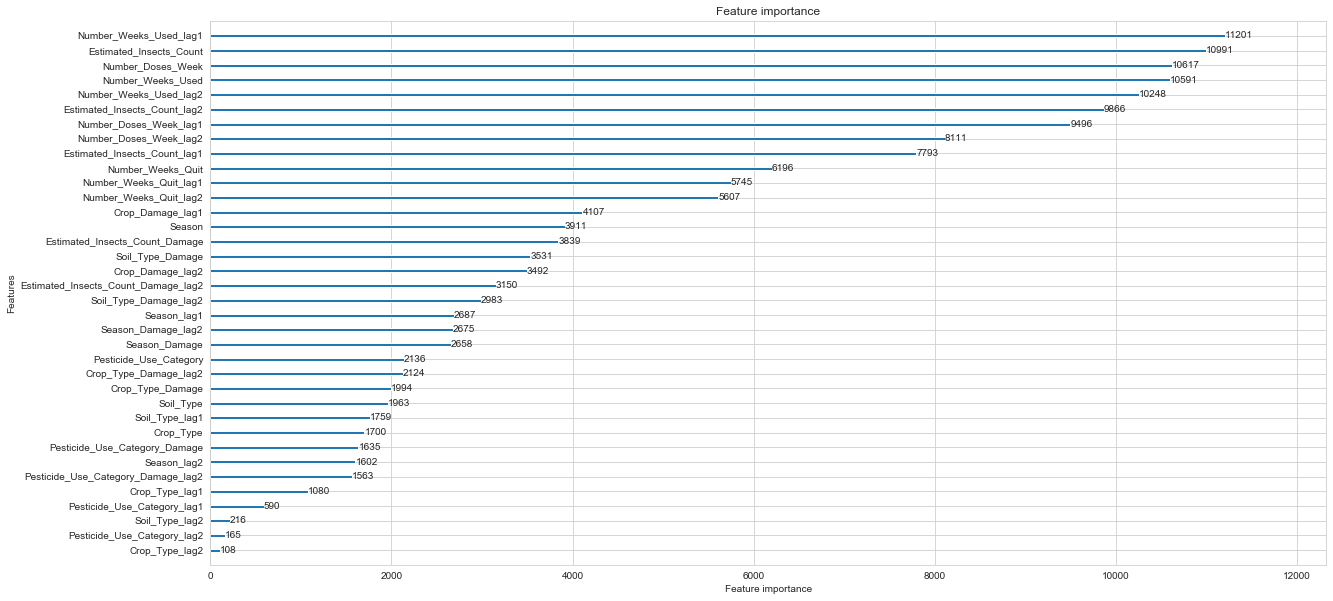

In [36]:
plt.rcParams['figure.figsize'] = (20, 10)
lgb.plot_importance(clf)
plt.show()

In [39]:
# Private leaderboard score for this submission is : 0.9534760261576699